In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LogisticRegression
from dateutil.parser import parse

In [8]:
train=pd.read_csv("./WNS//train.csv",parse_dates=['impression_time'])
test=pd.read_csv("./WNS//test.csv",parse_dates=['impression_time'])
item=pd.read_csv("./WNS/item_data.csv")
view=pd.read_csv("./WNS/view_log.csv",parse_dates=['server_time'])
submission=pd.read_csv("./WNS/sample_submission.csv")

In [9]:
print(train.info(),"\n")
print(test.info(),"\n")
print(item.info(),"\n")
print(view.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null datetime64[ns]
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 12.7+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 6 columns):
impression_id      90675 non-null object
impression_time    90675 non-null datetime64[ns]
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Da

In [10]:
print("train data null check\n",train.isnull().sum(),"\n\n")
print("test data null check\n",test.isnull().sum(),"\n\n")
print("item data null check\n",item.isnull().sum(),"\n\n")
print("view data null check\n",view.isnull().sum())


train data null check
 impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64 


test data null check
 impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
dtype: int64 


item data null check
 item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64 


view data null check
 server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64


In [11]:
def unique_count(data,data_name):
    print("Size of {} dataset".format(data_name),len(data))
    print("Checking unique count for each column in {} dataset".format(data_name))
    for name in data.columns:
        print("Unique count",name,len(data[str(name)].unique()))
    print("\n")
    


In [12]:
unique_count(train,'train')
unique_count(test,'test')
unique_count(item,'item')
unique_count(view,'view')

Size of train dataset 237609
Checking unique count for each column in train dataset
Unique count impression_id 237609
Unique count impression_time 36461
Unique count user_id 74723
Unique count app_code 490
Unique count os_version 3
Unique count is_4G 2
Unique count is_click 2


Size of test dataset 90675
Checking unique count for each column in test dataset
Unique count impression_id 90675
Unique count impression_time 9636
Unique count user_id 34079
Unique count app_code 373
Unique count os_version 3
Unique count is_4G 2


Size of item dataset 132761
Checking unique count for each column in item dataset
Unique count item_id 132761
Unique count item_price 13531
Unique count category_1 17
Unique count category_2 79
Unique count category_3 335
Unique count product_type 7959


Size of view dataset 3118622
Checking unique count for each column in view dataset
Unique count server_time 82840
Unique count device_type 3
Unique count session_id 1014970
Unique count user_id 89157
Unique count ite

In [30]:
test['is_click']=0
train['is_train']=1
test['is_train']=0
train_test=pd.concat([train,test],axis=0)

In [31]:
#creating new features based on impression_time
train_test['day']=train_test['impression_time'].apply(lambda x:x.day)
train_test['month']=train_test['impression_time'].apply(lambda x:x.month)
train_test['week_day']=train_test['impression_time'].apply(lambda x:x.weekday())
train_test['time']=train_test['impression_time'].apply(lambda x:x.time().hour)

In [ ]:
#Counting no of site visits by user per session id
site_visit_count=view.groupby(by=['user_id','session_id'],as_index=False)['server_time'].count()
site_visit_count.rename(columns={'server_time':'n_visit'},inplace=True)

In [35]:
#combining view and item data set
view1=pd.merge(view,site_visit_count,how='left',on=['user_id','session_id'])
view_item_comb=pd.merge(view,item,how='left',on='item_id')

In [36]:
#mergiing all the three dataset i.e train/test,view and item on user_id
final=pd.merge(train_test,view_item_comb,how='left',on='user_id')

In [38]:
#Creating new feature 'diff' based on time difference between site visit and ad impression
final['diff']=final['impression_time']-final['server_time']
final['diff']=final['diff'].dt.days

In [59]:
# replacing NA with their mean and max frequency value
final.item_price.fillna(final.item_price.mean(),inplace=True)
final.category_1.fillna(9,inplace=True)
final.category_2.fillna(38,inplace=True)
final.category_3.fillna(62,inplace=True)
final.product_type.fillna(2874,inplace=True)


In [65]:
#Removing rows where impression time<server time
final1=final[final.impression_time>final.server_time]

In [66]:
final1.drop(['server_time'],axis=1,inplace=True)

In [70]:
len(final1)

9800453

In [69]:
final1=final1.drop_duplicates(keep='first')

In [71]:

os_version=pd.get_dummies(final1.os_version,prefix='os',drop_first=True)
device_type=pd.get_dummies(final1.device_type,prefix='device',drop_first=True)


In [72]:
final1=pd.concat([final1,os_version,device_type],axis=1)

In [73]:
final_train=final1[final1.is_train==1]
final_test=final1[final1.is_train==0]

In [ ]:
,'category_1', 'category_2', 'category_3'

In [74]:
y=final_train.is_click
X=final_train.drop(['impression_id','impression_time','user_id','is_click','is_train','session_id','item_id',\
                    'device_type','os_version'],axis=1)

x_impression_id=final_test[['impression_id']]
x_impression_id.reset_index(drop=True,inplace=True)

X_test=final_test.drop(['impression_id','impression_time','user_id','is_click','is_train','session_id','item_id',\
                       'device_type','os_version'],axis=1)



In [76]:
X_test.columns

Index(['app_code', 'is_4G', 'day', 'month', 'week_day', 'time', 'n_visit',
       'item_price', 'category_1', 'category_2', 'category_3', 'product_type',
       'diff', 'os_latest', 'os_old', 'device_iphone', 'device_web'],
      dtype='object')

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_sample(x, y)

In [78]:
# models
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import catboost as cb


LR=LogisticRegression()

XGB=XGBClassifier(
 learning_rate =0.08,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 eval_metric = 'auc',
 seed=27)

CB=cb.CatBoostClassifier()


In [79]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
from sklearn.model_selection import train_test_split

In [82]:
def prediction(model,X,y,X_test,submission_file):
    clf=model.fit(X,y)
    y_pred=clf.predict(X)
    
    print("Training Data metrics")
    print("accuracy_score={0} and f1_score={1}".format(accuracy_score(y,y_pred),f1_score(y,y_pred)))
    print("Confusion Matrix")
    print(confusion_matrix(y,y_pred))
    print("\n")
    print("classification report")
    print(classification_report(y,y_pred))
    
    test_predict=clf.predict_proba(X_test)
    sol=pd.DataFrame(test_predict[:,1])
    sol.columns=['prob']
    sol1=pd.concat([x_impression_id,sol],axis=1)
    sol2=sol1.groupby('impression_id',as_index=False)['prob'].mean()
    sol2=pd.DataFrame(sol2)
    submission=pd.merge(submission_file,sol2,how='left',on='impression_id').drop('is_click',axis=1)
    submission.rename(columns={'prob':'is_click'},inplace=True)
    submission.to_csv("./WNS/submission.csv",index=False)
    return clf

In [83]:
classifier_xgb=prediction(XGB,X,y,X_test,submission)

[15:48:28] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


C:\Users\Lalit\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training Data metrics
accuracy_score=0.9423875821071221 and f1_score=0.007441746357070936
Confusion Matrix
[[6351648       4]
 [ 388390    1456]]


classification report
             precision    recall  f1-score   support

          0       0.94      1.00      0.97   6351652
          1       1.00      0.00      0.01    389846

avg / total       0.95      0.94      0.91   6741498



In [84]:
importance=classifier_xgb.feature_importances_

In [85]:
imp=pd.DataFrame(importance,index=X.columns)

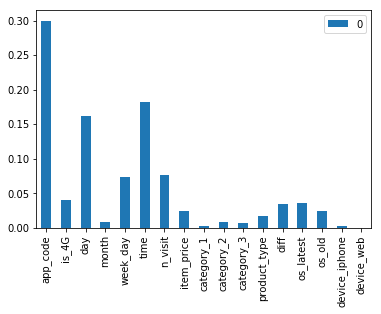

In [86]:
imp.plot(kind='bar')

In [87]:


classifier_cb=prediction(CB,X,y,X_test,submission)

Learning rate set to 0.203078
0:	learn: 0.4808205	total: 2.39s	remaining: 39m 45s
1:	learn: 0.3661879	total: 5.01s	remaining: 41m 41s
2:	learn: 0.2998549	total: 7.56s	remaining: 41m 52s
3:	learn: 0.2647542	total: 9.77s	remaining: 40m 31s
4:	learn: 0.2449497	total: 11.9s	remaining: 39m 38s
5:	learn: 0.2308526	total: 14.4s	remaining: 39m 38s
6:	learn: 0.2246990	total: 16.7s	remaining: 39m 25s
7:	learn: 0.2200383	total: 18.9s	remaining: 39m 9s
8:	learn: 0.2165072	total: 21s	remaining: 38m 31s
9:	learn: 0.2143297	total: 23.5s	remaining: 38m 41s
10:	learn: 0.2133438	total: 25.9s	remaining: 38m 45s
11:	learn: 0.2123169	total: 28.2s	remaining: 38m 43s
12:	learn: 0.2113645	total: 30.3s	remaining: 38m 18s
13:	learn: 0.2110694	total: 32.6s	remaining: 38m 15s
14:	learn: 0.2108508	total: 35.2s	remaining: 38m 29s
15:	learn: 0.2105519	total: 37.6s	remaining: 38m 35s
16:	learn: 0.2101932	total: 40s	remaining: 38m 35s
17:	learn: 0.2098785	total: 42s	remaining: 38m 13s
18:	learn: 0.2096124	total: 44.5s

153:	learn: 0.1955032	total: 6m 15s	remaining: 34m 25s
154:	learn: 0.1953974	total: 6m 18s	remaining: 34m 24s
155:	learn: 0.1953566	total: 6m 21s	remaining: 34m 21s
156:	learn: 0.1952920	total: 6m 23s	remaining: 34m 17s
157:	learn: 0.1952768	total: 6m 26s	remaining: 34m 17s
158:	learn: 0.1952001	total: 6m 28s	remaining: 34m 14s
159:	learn: 0.1951426	total: 6m 30s	remaining: 34m 9s
160:	learn: 0.1950889	total: 6m 33s	remaining: 34m 10s
161:	learn: 0.1950287	total: 6m 35s	remaining: 34m 7s
162:	learn: 0.1949720	total: 6m 38s	remaining: 34m 6s
163:	learn: 0.1949140	total: 6m 40s	remaining: 34m 3s
164:	learn: 0.1948424	total: 6m 43s	remaining: 34m
165:	learn: 0.1948044	total: 6m 45s	remaining: 33m 59s
166:	learn: 0.1947236	total: 6m 48s	remaining: 33m 56s
167:	learn: 0.1946468	total: 6m 50s	remaining: 33m 54s
168:	learn: 0.1946053	total: 6m 53s	remaining: 33m 52s
169:	learn: 0.1945168	total: 6m 55s	remaining: 33m 48s
170:	learn: 0.1944444	total: 6m 58s	remaining: 33m 46s
171:	learn: 0.1943

303:	learn: 0.1878746	total: 12m 24s	remaining: 28m 25s
304:	learn: 0.1878684	total: 12m 27s	remaining: 28m 22s
305:	learn: 0.1878642	total: 12m 29s	remaining: 28m 20s
306:	learn: 0.1878022	total: 12m 32s	remaining: 28m 17s
307:	learn: 0.1877477	total: 12m 34s	remaining: 28m 15s
308:	learn: 0.1876553	total: 12m 37s	remaining: 28m 12s
309:	learn: 0.1876122	total: 12m 39s	remaining: 28m 11s
310:	learn: 0.1875279	total: 12m 41s	remaining: 28m 8s
311:	learn: 0.1874814	total: 12m 44s	remaining: 28m 5s
312:	learn: 0.1874067	total: 12m 46s	remaining: 28m 3s
313:	learn: 0.1873442	total: 12m 49s	remaining: 28m
314:	learn: 0.1872990	total: 12m 51s	remaining: 27m 58s
315:	learn: 0.1872391	total: 12m 54s	remaining: 27m 56s
316:	learn: 0.1871978	total: 12m 56s	remaining: 27m 53s
317:	learn: 0.1871918	total: 12m 59s	remaining: 27m 51s
318:	learn: 0.1871829	total: 13m 1s	remaining: 27m 48s
319:	learn: 0.1871608	total: 13m 4s	remaining: 27m 46s
320:	learn: 0.1871018	total: 13m 6s	remaining: 27m 43s
32

451:	learn: 0.1822613	total: 18m 29s	remaining: 22m 25s
452:	learn: 0.1821804	total: 18m 31s	remaining: 22m 22s
453:	learn: 0.1821758	total: 18m 34s	remaining: 22m 20s
454:	learn: 0.1821336	total: 18m 37s	remaining: 22m 18s
455:	learn: 0.1821068	total: 18m 39s	remaining: 22m 15s
456:	learn: 0.1820337	total: 18m 42s	remaining: 22m 13s
457:	learn: 0.1819934	total: 18m 44s	remaining: 22m 10s
458:	learn: 0.1819730	total: 18m 46s	remaining: 22m 8s
459:	learn: 0.1819315	total: 18m 49s	remaining: 22m 6s
460:	learn: 0.1818949	total: 18m 51s	remaining: 22m 3s
461:	learn: 0.1818695	total: 18m 54s	remaining: 22m 1s
462:	learn: 0.1818055	total: 18m 56s	remaining: 21m 58s
463:	learn: 0.1817810	total: 18m 58s	remaining: 21m 55s
464:	learn: 0.1817646	total: 19m 1s	remaining: 21m 53s
465:	learn: 0.1817300	total: 19m 3s	remaining: 21m 50s
466:	learn: 0.1816778	total: 19m 6s	remaining: 21m 48s
467:	learn: 0.1816567	total: 19m 8s	remaining: 21m 46s
468:	learn: 0.1816389	total: 19m 11s	remaining: 21m 43s


599:	learn: 0.1778298	total: 24m 35s	remaining: 16m 23s
600:	learn: 0.1777927	total: 24m 37s	remaining: 16m 21s
601:	learn: 0.1777865	total: 24m 39s	remaining: 16m 18s
602:	learn: 0.1777495	total: 24m 42s	remaining: 16m 16s
603:	learn: 0.1777160	total: 24m 45s	remaining: 16m 13s
604:	learn: 0.1776826	total: 24m 47s	remaining: 16m 11s
605:	learn: 0.1776788	total: 24m 50s	remaining: 16m 8s
606:	learn: 0.1776444	total: 24m 52s	remaining: 16m 6s
607:	learn: 0.1776397	total: 24m 55s	remaining: 16m 3s
608:	learn: 0.1776064	total: 24m 57s	remaining: 16m 1s
609:	learn: 0.1776033	total: 24m 59s	remaining: 15m 58s
610:	learn: 0.1775987	total: 25m 2s	remaining: 15m 56s
611:	learn: 0.1775829	total: 25m 4s	remaining: 15m 54s
612:	learn: 0.1775536	total: 25m 7s	remaining: 15m 51s
613:	learn: 0.1775390	total: 25m 9s	remaining: 15m 49s
614:	learn: 0.1775285	total: 25m 12s	remaining: 15m 46s
615:	learn: 0.1775155	total: 25m 14s	remaining: 15m 44s
616:	learn: 0.1775017	total: 25m 17s	remaining: 15m 41s


747:	learn: 0.1744705	total: 30m 39s	remaining: 10m 19s
748:	learn: 0.1744398	total: 30m 41s	remaining: 10m 17s
749:	learn: 0.1743737	total: 30m 43s	remaining: 10m 14s
750:	learn: 0.1743699	total: 30m 46s	remaining: 10m 12s
751:	learn: 0.1743543	total: 30m 48s	remaining: 10m 9s
752:	learn: 0.1743334	total: 30m 51s	remaining: 10m 7s
753:	learn: 0.1743214	total: 30m 53s	remaining: 10m 4s
754:	learn: 0.1743147	total: 30m 56s	remaining: 10m 2s
755:	learn: 0.1742911	total: 30m 58s	remaining: 9m 59s
756:	learn: 0.1742757	total: 31m	remaining: 9m 57s
757:	learn: 0.1742404	total: 31m 3s	remaining: 9m 54s
758:	learn: 0.1741884	total: 31m 5s	remaining: 9m 52s
759:	learn: 0.1741847	total: 31m 8s	remaining: 9m 49s
760:	learn: 0.1741676	total: 31m 10s	remaining: 9m 47s
761:	learn: 0.1741241	total: 31m 13s	remaining: 9m 45s
762:	learn: 0.1741218	total: 31m 16s	remaining: 9m 42s
763:	learn: 0.1741122	total: 31m 18s	remaining: 9m 40s
764:	learn: 0.1740895	total: 31m 20s	remaining: 9m 37s
765:	learn: 0

898:	learn: 0.1714532	total: 36m 50s	remaining: 4m 8s
899:	learn: 0.1714444	total: 36m 52s	remaining: 4m 5s
900:	learn: 0.1714361	total: 36m 54s	remaining: 4m 3s
901:	learn: 0.1714061	total: 36m 56s	remaining: 4m
902:	learn: 0.1713836	total: 36m 59s	remaining: 3m 58s
903:	learn: 0.1713671	total: 37m 2s	remaining: 3m 55s
904:	learn: 0.1713425	total: 37m 4s	remaining: 3m 53s
905:	learn: 0.1713129	total: 37m 7s	remaining: 3m 51s
906:	learn: 0.1713058	total: 37m 9s	remaining: 3m 48s
907:	learn: 0.1713029	total: 37m 12s	remaining: 3m 46s
908:	learn: 0.1712893	total: 37m 14s	remaining: 3m 43s
909:	learn: 0.1712700	total: 37m 17s	remaining: 3m 41s
910:	learn: 0.1712570	total: 37m 19s	remaining: 3m 38s
911:	learn: 0.1712469	total: 37m 21s	remaining: 3m 36s
912:	learn: 0.1712342	total: 37m 24s	remaining: 3m 33s
913:	learn: 0.1712204	total: 37m 26s	remaining: 3m 31s
914:	learn: 0.1712114	total: 37m 29s	remaining: 3m 28s
915:	learn: 0.1711922	total: 37m 31s	remaining: 3m 26s
916:	learn: 0.1711872

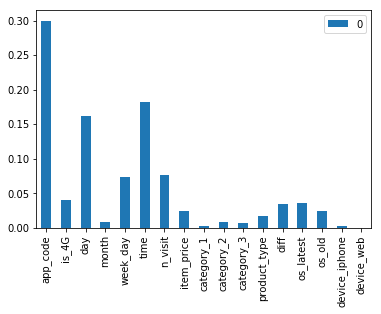

In [89]:
importance_cb=classifier_cb.feature_importances_
imp_cb=pd.DataFrame(importance_cb,index=X.columns)
imp.plot(kind='bar')